# Deep learning volatility

**Abstract:**

*We present a consistent neural network based calibration method for a number of volatility models-including the rough volatility family-that performs the calibration task within a few milliseconds for the full implied volatility surface.*

*The aim of neural networks in this work is an off-line approximation of complex pricing functions, which are difficult to represent or time-consuming to evaluate by other means. We highlight how this perspective opens new horizons for quantitative modelling: The calibration bottleneck posed by a slow pricing of derivative contracts is lifted. This brings several model families (such as rough volatility models) within the scope of applicability in industry practice. As customary for machine learning, the form in which information from available data is extracted and stored is crucial for network performance. With this in mind we discuss how our approach addresses the usual challenges of machine learning solutions in a financial context (availability of training data, interpretability of results for regulators, control over generalisation errors). We present specific architectures for price approximation and calibration and optimize these with respect different objectives regarding accuracy, speed and robustness. We also find that including the intermediate step of learning pricing functions of (classical or rough) models before calibration significantly improves network performance compared to direct calibration to data.*

**Reference:** *Horvath, B., Muguruza, A. and Tomas, M., 2019. Deep Learning Volatility. Available at SSRN 3322085.*

Throughout this presentation, we will use the rough Bergomi model as an example for the methodology, insisting on the fact it is model independent. We will also use a fixed grid of points to represent the implied volatility surface.

In [4]:
import os
os.chdir("../NN-StochVol-Calibrations/Data")

In [42]:
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
f = gzip.GzipFile('HestonTrainSet.txt.gz', "r")
dat=np.load(f)
xx=dat[:,:5]
yy=dat[:,5:]
print(xx.shape)
print(yy.shape)
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])
logmoneyness = np.log(strikes/1.0)
print(logmoneyness)
xx[0],yy[0][:11]

(12000, 5)
(12000, 88)
[-0.69314718 -0.51082562 -0.35667494 -0.22314355 -0.10536052  0.
  0.09531018  0.18232156  0.26236426  0.33647224  0.40546511]


(array([ 0.01683994, -0.12410636,  0.87622854,  0.16472127,  9.58028822]),
 array([0.35127464, 0.32127172, 0.29482681, 0.27288942, 0.25897266,
        0.25824184, 0.26936823, 0.28519109, 0.30141773, 0.31668197,
        0.33070043]))

# Step 1: Data Generation


## **Inputs:** 
###  1. $\rho$ spot-vol correlation,
###  2. $\nu$ vol of vol
###  3. $\theta$ long term vol
###  4. $\kappa$ speed of mean reversion 
###  5. $\xi_{0}$ forward variance curve
    
    
## **Outputs:**
### Implied volatility surface (11x8=88 points)

# Scaling:

# Model Parameters $\theta\to scale(\theta)\in[-1,1]$
## $scale(\theta^i)=\frac{2\theta^i-(\theta^i_{max}-\theta^i_{min})}{\theta^i_{max}-\theta^i_{min}},\quad i \in |\Theta|$

# Implied volatilities
## $$scale(\sigma_{BS}^{i,j})=\frac{\sigma_{BS}^{i,j}-\mathbb{E}[\sigma_{BS}^{i,j}]}{std(\sigma_{BS}^{i,j})},\quad i\in\text{Maturities},\; j\in \text{Strikes}$$

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
     xx,yy, test_size=0.15, random_state=42)
from sklearn.preprocessing import StandardScaler



In [9]:
ub=[0.04,-0.1,1.0,0.2,10.0]
lb=[0.0001,-0.95,0.01,0.01,1]
def myscale(x):
    res=np.zeros(5)
    for i in range(5):
        res[i]=(x[i] - (ub[i] + lb[i])*0.5) * 2 / (ub[i] - lb[i])
        
    return res
def myinverse(x):
    res=np.zeros(5)
    for i in range(5):
        res[i]=x[i]*(ub[i] - lb[i]) *0.5 + (ub[i] + lb[i])*0.5
        
    return res

In [13]:
x_train_transform = np.array([myscale(x) for x in X_train])
x_test_transform = np.array([myscale(x) for x in X_test])

# Create the Neural Network

In [14]:
import keras
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
keras.backend.set_floatx('float64')


input1 = keras.layers.Input(shape=(5,))
x1 = keras.layers.Dense(30,activation = 'elu')(input1)
x2=keras.layers.Dense(30,activation = 'elu')(x1) 
x3=keras.layers.Dense(30,activation = 'elu')(x2) 


x4=keras.layers.Dense(88,activation = 'linear')(x3)


modelGEN = keras.models.Model(inputs=input1, outputs=x4)
modelGEN.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 30)                180       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_6 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_7 (Dense)              (None, 88)                2728      
Total params: 4,768
Trainable params: 4,768
Non-trainable params: 0
_________________________________________________________________


# Fit the Neural Network (No need to run the code, parameters are stored on a .h5 file)

In [16]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
modelGEN.compile(loss = root_mean_squared_error, optimizer = "adam")

modelGEN.fit(x_train_transform, y_train, batch_size=32,validation_data = (x_test_transform, y_test),epochs = 200, verbose = True,shuffle=1)#,callbacks=[earlystop])

Epoch 1/200
319/319 [==============================] - 0s 2ms/step - loss: 0.0099 - val_loss: 0.0082
Epoch 2/200
319/319 [==============================] - 0s 1ms/step - loss: 0.0072 - val_loss: 0.0063
Epoch 3/200
319/319 [==============================] - 0s 1ms/step - loss: 0.0062 - val_loss: 0.0056
Epoch 4/200
319/319 [==============================] - 0s 1ms/step - loss: 0.0056 - val_loss: 0.0059
Epoch 5/200
319/319 [==============================] - 0s 1ms/step - loss: 0.0052 - val_loss: 0.0054
Epoch 6/200
319/319 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0060
Epoch 7/200
319/319 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 8/200
319/319 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 9/200
319/319 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 10/200
319/319 [==============================] - 0s 1ms/step - loss: 0.0041 - val_lo

319/319 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 82/200
319/319 [==============================] - 0s 996us/step - loss: 0.0020 - val_loss: 0.0027
Epoch 83/200
319/319 [==============================] - 0s 985us/step - loss: 0.0020 - val_loss: 0.0019
Epoch 84/200
319/319 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 85/200
319/319 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 86/200
319/319 [==============================] - 0s 993us/step - loss: 0.0019 - val_loss: 0.0019
Epoch 87/200
319/319 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 88/200
319/319 [==============================] - 0s 998us/step - loss: 0.0021 - val_loss: 0.0019
Epoch 89/200
319/319 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 90/200
319/319 [==============================] - 0s 1ms/step - loss: 0.0020 - va

319/319 [==============================] - 0s 998us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 161/200
319/319 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 162/200
319/319 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 163/200
319/319 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 164/200
319/319 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 165/200
319/319 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 166/200
319/319 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 167/200
319/319 [==============================] - 0s 991us/step - loss: 0.0016 - val_loss: 0.0015
Epoch 168/200
319/319 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 169/200
319/319 [==============================] - 0s 1ms/step - loss: 0.0016

## Store/Load optimal NN parameteres

In [17]:
modelGEN.save_weights('HestonNNWeights.h5')

In [18]:
modelGEN.load_weights('HestonNNWeights.h5')

In [19]:
NNParameters=[]
for i in range(1,len(modelGEN.layers)):
    NNParameters.append(modelGEN.layers[i].get_weights())

# Numpy Implementation of the Neural Network tends to be faster than Keras

In [20]:
NumLayers=3
def elu(x):
    #Careful function ovewrites x
    ind=(x<0)
    x[ind]=np.exp(x[ind])-1
    return x
def eluPrime(y):
    # we make a deep copy of input x
    x=np.copy(y)
    ind=(x<0)
    x[ind]=np.exp(x[ind])
    x[~ind]=1
    return x
def NeuralNetwork(x):
    input1=x
    for i in range(NumLayers):
        input1=np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
        #Elu activation
        input1=elu(input1)
    #The output layer is linnear
    i+=1
    return np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
def NeuralNetworkGradient(x):
    input1=x
    #Identity Matrix represents Jacobian with respect to initial parameters
    grad=np.eye(5)
    #Propagate the gradient via chain rule
    for i in range(NumLayers):
        input1=(np.dot(input1,NNParameters[i][0])+NNParameters[i][1])
        grad=(np.einsum('ij,jk->ik', grad, NNParameters[i][0]))
        #Elu activation
        grad*=eluPrime(input1)
        input1=elu(input1)
    #input1.append(np.dot(input1[i],NNParameters[i+1][0])+NNParameters[i+1][1])
    grad=np.einsum('ij,jk->ik',grad,NNParameters[i+1][0])
    #grad stores all intermediate Jacobians, however only the last one is used here as output
    return grad

In [21]:
S0=1.
strikes_dim=len(strikes)
maturities_dim=len(maturities)

# Compute Implied vol relative errors on Test set

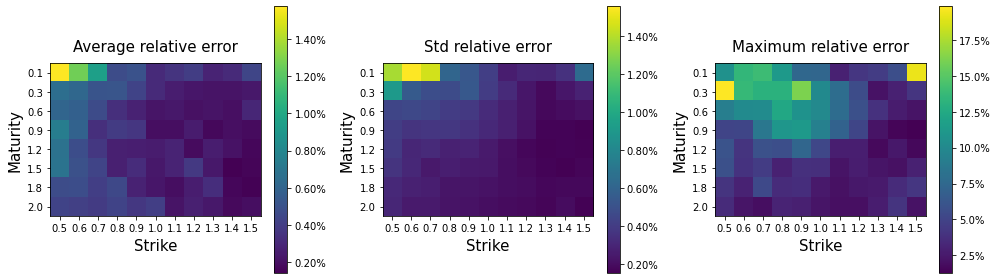

In [24]:
import numpy as np
import csv
S0=1.
strikes_dim=len(strikes)
maturities_dim=len(maturities)
strikeslabel=np.round(np.linspace(strikes[0],strikes[-1],8),1)
maturitieslabel=np.array([0.1,0.2, 0.6, 1.5,1.8])
##### AVERAGE VALUES #######
X_sample = x_test_transform
y_sample = y_test

prediction=[NeuralNetwork(X_sample[i]) for i in range(len(X_sample))]
plt.figure(1,figsize=(14,4))
ax=plt.subplot(1,3,1)
err = np.mean(100*np.abs((y_sample-prediction)/y_sample),axis = 0)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,2)
err = 100*np.std(np.abs((y_sample-prediction)/y_sample),axis = 0)
plt.title("Std relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,3)
err = 100*np.max(np.abs((y_sample-prediction)/y_sample),axis = 0)
plt.title("Maximum relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
plt.tight_layout()
plt.savefig('HestonNNErrors.png', dpi=300)
plt.show()


# Plot sample Smiles

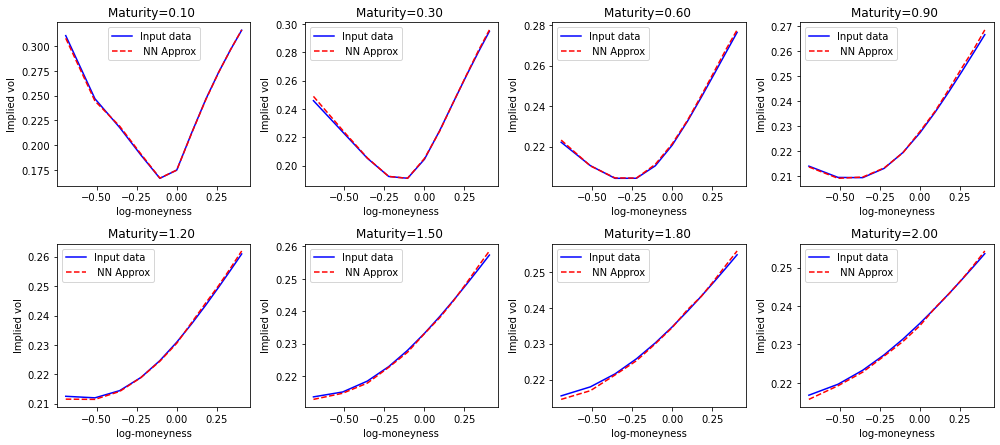

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import scipy
S0=1.

sample_ind = 1250
X_sample = x_test_transform[sample_ind]
y_sample = y_test[sample_ind]
# print(scale.inverse_transform(y_sample))

prediction=NeuralNetwork(X_sample)
plt.figure(1,figsize=(14,12))
for i in range(maturities_dim):
    plt.subplot(4,4,i+1)
    
    plt.plot(np.log(strikes/S0),y_sample[i*strikes_dim:(i+1)*strikes_dim],'b',label="Input data")
    plt.plot(np.log(strikes/S0),prediction[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" NN Approx")

    
    plt.title("Maturity=%1.2f "%maturities[i])
    plt.xlabel("log-moneyness")
    plt.ylabel("Implied vol")
    
    plt.legend()
plt.tight_layout()
plt.show()

# Use gradient methods for optimisation

In [27]:
def CostFunc(x,sample_ind):
    return np.sum(np.power((NeuralNetwork(x)-y_test[sample_ind]),2))
def Jacobian(x,sample_ind):
    return 2*np.sum((NeuralNetwork(x)-y_test[sample_ind])*NeuralNetworkGradient(x),axis=1)
#Cost Function for Levenberg Marquardt
def CostFuncLS(x,sample_ind):
    return (NeuralNetwork(x)-y_test[sample_ind])
def JacobianLS(x,sample_ind):
    return NeuralNetworkGradient(x).T

In [28]:
import time
import scipy
Approx=[]
Timing=[]
sample_ind = 500
X_sample = x_test_transform[sample_ind]
y_sample = y_test[sample_ind]
solutions=np.zeros([4,5])
times=np.zeros(4)
init=np.zeros(5)
for i in range(1800):
    disp=str(i+1)+"/1800"
    print (disp,end="\r")
    #L-BFGS-B
    start= time.time()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='L-BFGS-B',jac=Jacobian,tol=1E-10,options={"maxiter":5000})
    end= time.time()
    solutions[0,:]=myinverse(I.x)
    times[0]=end-start
    #SLSQP
    start= time.time()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='SLSQP',jac=Jacobian,tol=1E-10,options={"maxiter":5000})
    end= time.time()
    solutions[1,:]=myinverse(I.x)
    times[1]=end-start
    #BFGS
    start= time.time()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='BFGS',jac=Jacobian,tol=1E-10,options={"maxiter":5000})
    end= time.time()
    solutions[2,:]=myinverse(I.x)
    times[2]=end-start
    #Levenberg-Marquardt
    start= time.time()
    I=scipy.optimize.least_squares(CostFuncLS,init, JacobianLS,args=(i,),gtol=1E-10)
    end= time.time()
    solutions[3,:]=myinverse(I.x)
    times[3]=end-start
    
    Approx.append(np.copy(solutions))
    Timing.append(np.copy(times))

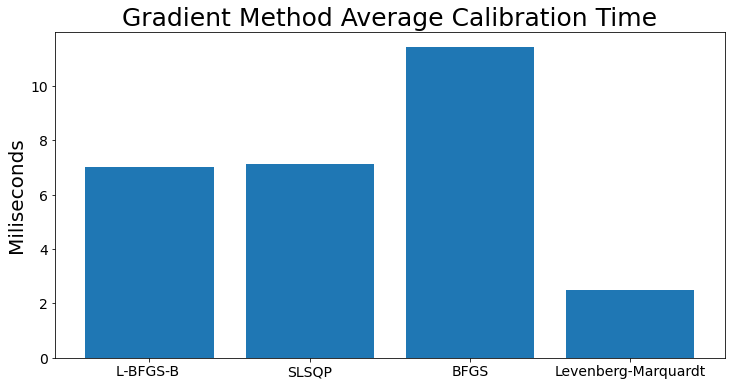

In [29]:
methods=["L-BFGS-B ","SLSQP","BFGS","Levenberg-Marquardt"]
plt.figure(1,figsize=(12,6))
plt.bar(methods,np.mean(Timing,axis=0)*1000)
plt.title("Gradient Method Average Calibration Time",fontsize=25)
plt.ylabel("Miliseconds",fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

# Save the Lavenberg-Marquardt Optimal parameters

In [36]:
for j in range(4):
    LMParameters=[Approx[i][j] for i in range(len(Approx))]
np.savetxt("NNParametersHeston.txt",LMParameters)
LMParameters = np.loadtxt("../Data/NNParametersHeston.txt")
# np.shape(LMParameters)
# print(100*np.abs(LMParameters[:1800,u]))
#     print(np.mean(LMParameters, axis=0))
LMParameters[:10]

array([[ 2.39808467e-03, -9.03320843e-02,  6.81095826e-01,
         1.92490828e-01,  5.63295151e+00],
       [ 3.01318600e-02, -3.29485300e-01,  5.83853740e-02,
         1.42577579e-01,  9.01341692e+00],
       [ 3.66082372e-03, -5.02421565e-01,  7.95139733e-01,
         1.32866970e-01,  4.68343288e+00],
       [ 2.92600751e-02, -3.55751799e-01,  3.69197579e-01,
         1.84547658e-01,  7.71085006e+00],
       [ 1.17819622e-02, -1.50926683e-01,  6.86980158e-01,
         1.89892898e-01,  6.71646124e+00],
       [ 3.59820405e-02, -9.63104479e-02,  8.67794921e-01,
         8.96814572e-02,  7.86335967e+00],
       [ 3.46031972e-02, -3.85768295e-01,  8.22435085e-01,
         1.65832833e-01,  8.06320032e+00],
       [ 3.55031262e-02, -3.00667543e-01,  1.21665983e-01,
         1.06287357e-01,  7.17953047e+00],
       [ 3.49645147e-02, -1.19889088e-01,  9.72175211e-01,
         1.50268160e-01,  4.64541309e+00],
       [ 1.32696312e-02, -3.06962618e-01,  7.63154848e-01,
         1.61296520e-01

# Calibration Errors with Levenberg-Marquardt

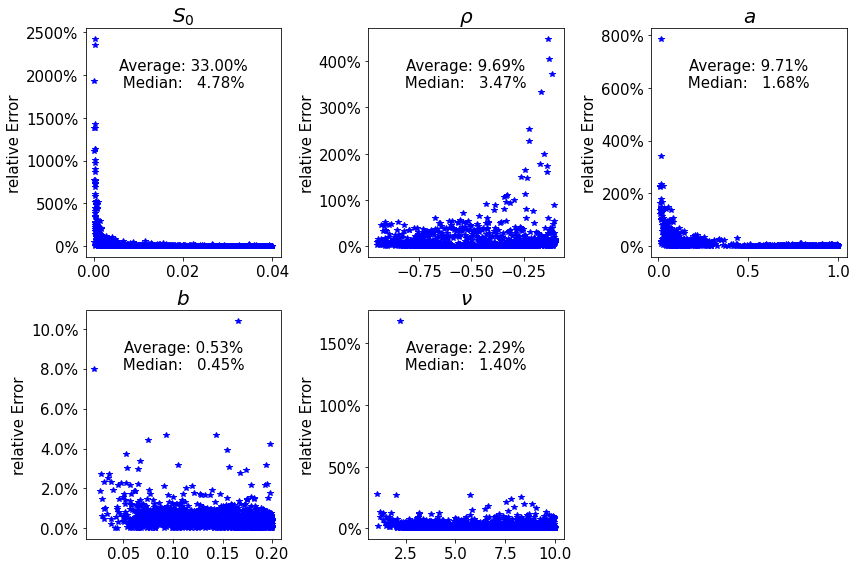

In [53]:
titles=["$S_0$","$\\rho$","$a$","$b$", "$\\nu$"]
average=np.zeros([5,1800])
fig=plt.figure(figsize=(12,8))
for u in range(5):
    ax=plt.subplot(2,3,u+1)
    y=X_test[:1800,u]
    plt.plot(y,100*np.abs(LMParameters[:1800,u]-y)/np.abs(y),'b*')
    average[u,:]=np.abs(LMParameters[:1800,u]-y)/np.abs(y)
    
    plt.title(titles[u],fontsize=20)
    plt.ylabel('relative Error',fontsize=15)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    plt.text(0.5, 0.8, 'Average: %1.2f%%\n Median:   %1.2f%% '%(np.mean(100*average[u,:]),np.quantile(100*average[u,:],0.5)), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=15)
plt.tight_layout()

plt.savefig('HestonParameterRelativeErrors.png', dpi=300)
plt.show()

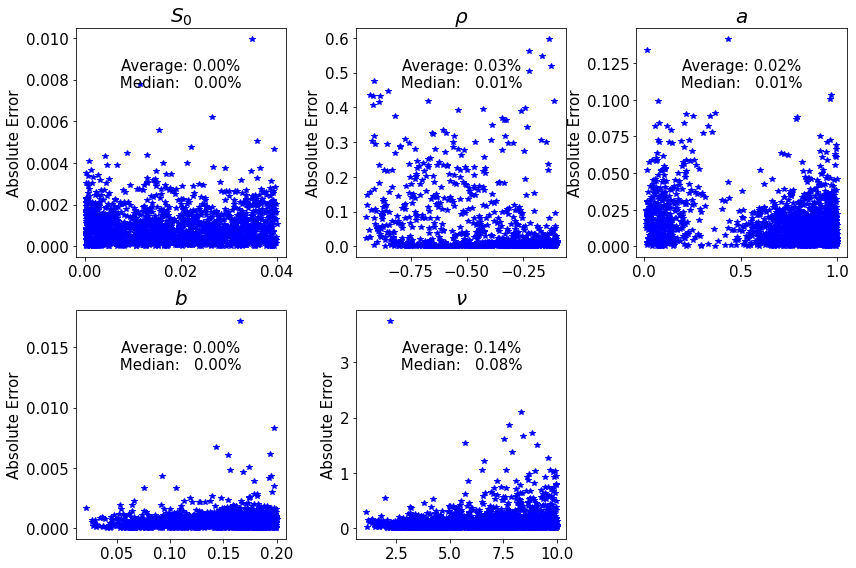

In [54]:
# titles=["$\\xi_0$","$\\rho$","$\\sigma$","$\\theta$", "$\\kappa$"]
titles=["$S_0$","$\\rho$","$a$","$b$", "$\\nu$"]

average=np.zeros([5,1800])
fig=plt.figure(figsize=(12,8))
for u in range(5):
    ax=plt.subplot(2,3,u+1)
    y=X_test[:1800,u]
    plt.plot(y,np.abs(LMParameters[:1800,u]-y),'b*')
    average[u,:]=np.abs(LMParameters[:1800,u]-y)
    
    plt.title(titles[u],fontsize=20)
    plt.ylabel('Absolute Error',fontsize=15)
    #plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    plt.text(0.5, 0.8, 'Average: %1.2f%%\n Median:   %1.2f%% '%(np.mean(average[u,:]),np.quantile(average[u,:],0.5)), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=15)
plt.tight_layout()

plt.savefig('HestonParameterAbsoluteErrors.png', dpi=300)
plt.show()

In [41]:
%config Completer.use_jedi=False

from scipy import  interpolate
from scipy.interpolate import griddata
import json
# logmoneyness = np.log(strikes/S0)
df_logmoneyness_market = json.load(open('../../Quadratic-rough-Heston/Data/logmoneyness_market.json'))
df_market = json.load(open('../../Quadratic-rough-Heston/Data/impliedVols_market.json'))
### maturities and strikes on the market
maturities_market = [0.06, 0.15, 0.31, 0.56]
print("Market logmoneyness: ",df_logmoneyness_market[10])
print("Model logmoneyness: ",np.round(logmoneyness,3))
print("Model Maturities: " ,maturities)
# df_market

Market logmoneyness:  [-0.118, -0.097, -0.077, -0.056, -0.008, 0.039, 0.083, 0.126, 0.167]
Model logmoneyness:  [-0.693 -0.511 -0.357 -0.223 -0.105  0.     0.095  0.182  0.262  0.336
  0.405]
Model Maturities:  [0.1 0.3 0.6 0.9 1.2 1.5 1.8 2. ]


In [43]:
def interpolation_NN(x, maturities_market, logmoneyness_market):
    """
    a function for the interpolation of the market data to the NeuralNetwork
    Input: 
        x: the input sample for the Neural Network function
        logmonyness_market(dim=9), maturities_market(dim=4)
    Output: 
        f: the interpolation results of the NeuralNetwork, 
        df: the interpolation results of the NeuralNetworkGradient
    """
    
    sbs = interpolate.RectBivariateSpline(maturities, logmoneyness, NeuralNetwork(x).reshape(maturities_dim,-1))
    fnew = sbs(maturities_market, logmoneyness_market) 
#     X,Y = np.meshgrid(logmoneyness, maturities)
#     sbs = interpolate.SmoothBivariateSpline(X.ravel(), Y.ravel(), NeuralNetwork(x))
#     return sbs(logmoneyness_market, maturities_market).ravel()
     
    return fnew.ravel()

def CostFunc_(x,sample_ind):
    logmoneyness_market = df_logmoneyness_market[sample_ind]
    interpolated = interpolation_NN(x,maturities_market, logmoneyness_market)
    return np.sum(np.power(interpolated - df_market[sample_ind], 2))

In [48]:
from scipy.optimize import  Bounds, LinearConstraint
bounds = Bounds([-1.]*6, [1.]*6)
l = np.array([1.,np.inf, np.inf, np.inf, np.inf])
constraints = LinearConstraint(np.diag(np.ones(5)), -l, l)

# constraints = LinearConstraint(np.diag(np.ones(6)), -np.ones(6), np.ones(6))

bounds = [(-1., 1.)]*5


In [49]:
import time 
Approx=[]
Timing = []

solutions=np.zeros([4,5])
# init = myscale(np.array([0.51, 1.2, 0.384, 0.095, 0.0025, 0.1]))
# init = myscale(init_lm)
init = np.zeros(5)
times = np.zeros(4)
for i in range(len(df_market)):
    disp=str(i+1)+"/" + str(len(df_market))
    print (disp, end="\r")
#     args=(i,)
    start= time.time()
    I=scipy.optimize.minimize(CostFunc_, x0=init, args=(i,), method='Powell', tol=1E-10,
                              bounds = bounds,
                              options={"maxiter": 5000})
    end= time.time()
    solutions[1, :]=myinverse(I.x)
    times[1] = end-start
    
    
    # Cobyla - gradient free method "
    start= time.time()
    I=scipy.optimize.minimize(CostFunc_, x0=init, args=(i,), method='COBYLA', tol=1E-10,
                              constraints = constraints,
                              options={"maxiter": 5000})
    end= time.time()
    solutions[2, :]=myinverse(I.x)
    times[2] = end-start
    
    ## Nelder-Mead Method
    start= time.time()
    I=scipy.optimize.minimize(CostFunc_, x0=init, args=(i,), method='Nelder-Mead', tol=1E-10,
                              bounds = bounds,
                              options={"maxiter": 5000, "adaptive":True})
    end= time.time()
    solutions[3, :]=myinverse(I.x)
    times[3] = end-start
    Approx.append(np.copy(solutions))
    Timing.append(np.copy(times))
    
print("time spent: %ss"%np.round(np.sum(Timing, axis=0), 6))

d:\programdata\anaconda3\envs\jia21\lib\site-packages\scipy\optimize\_constraints.py:388: OptimizeWarning: At least one constraint is unbounded above and below. Such constraints are ignored.
  warn("At least one constraint is unbounded above and below. Such "


time spent: [ 0.       47.315192 66.146353 87.272366]s


In [50]:
np.set_printoptions(formatter={'float': '{: 0.5f}'.format})
for i in range(20):
    print(Approx[i][1], Approx[i][3])

[ 0.04000 -0.10000  1.00000  0.07967  4.37429] [ 0.04000 -0.82584  0.01000  0.06732  10.00000]
[ 0.04000 -0.10000  1.00000  0.07997  4.42910] [ 0.04000 -0.82923  0.01000  0.06770  10.00000]
[ 0.04000 -0.10000  1.00000  0.07782  4.80519] [ 0.04000 -0.10000  1.00000  0.06789  10.00000]
[ 0.04000 -0.10000  1.00000  0.08030  4.47736] [ 0.04000 -0.82401  0.01000  0.06801  10.00000]
[ 0.04000 -0.10000  1.00000  0.08049  4.51325] [ 0.04000 -0.10000  1.00000  0.06800  10.00000]
[ 0.04000 -0.10000  1.00000  0.07800  4.85721] [ 0.04000 -0.82426  0.01000  0.06838  10.00000]
[ 0.04000 -0.10000  1.00000  0.08042  4.50881] [ 0.04000 -0.10000  1.00000  0.06802  10.00000]
[ 0.04000 -0.10000  1.00000  0.08084  4.56564] [ 0.04000 -0.82818  0.01000  0.06873  10.00000]
[ 0.04000 -0.10000  1.00000  0.07822  4.89282] [ 0.04000 -0.83060  0.01000  0.06855  10.00000]
[ 0.04000 -0.10000  1.00000  0.07621  4.75834] [ 0.04000 -0.86032  0.01000  0.06659  10.00000]
[ 0.04000 -0.10000  1.00000  0.07286  4.95576] [ 0

In [ ]:
### Interpolation figure
%matplotlib qt 

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(projection = '3d')
init = np.zeros(6)

X, Y = np.meshgrid(logmoneyness, maturities)
Z = NeuralNetwork(init).reshape(maturities_dim, -1)

logmoneyness_market = df_logmoneyness_market[0]
X1, Y1 = np.meshgrid(logmoneyness_market, maturities_market)
Z1 = interpolation_NN(init).reshape(len(maturities_market), -1)


surf = ax.plot_surface(X, Y, Z, cmap = cm.coolwarm, linewidth=0, antialiased=False, alpha=0.5)
points = ax.scatter(X1, Y1, Z1, c='g')

ax.set_xlabel("logmoneyness")
ax.set_ylabel("maturities")
ax.set_zlim(-.25, .4)
ax.zaxis.set_major_formatter("{x:.02f}")
fig.colorbar(surf, shrink=0.25, aspect=5)

plt.show()

In [ ]:
# %matplotlib inline

l = len(logmoneyness_market)
for sample_ind  in range(10):
    X_sample = myscale(Approx[sample_ind][3])
    y_sample = df_market[sample_ind]
    prediction=interpolation_NN(X_sample, maturities_market, df_logmoneyness_market[sample_ind])
    print("loss: ",CostFunc_(X_sample, sample_ind))
    print(Approx[sample_ind][3])
    
    plt.figure(1,figsize=(12,3))
    for i in range(len(maturities_market)):
        plt.subplot(1,4,i+1)
 
        plt.plot(logmoneyness_market, y_sample[i*l :(i+1)*l],'b',label="Input data")
        plt.plot(logmoneyness_market, prediction[i*l :(i+1)*l],'--r',label=" NN Approx")


        plt.title("Maturity=%1.2f "%maturities_market[i])
        plt.xlabel("log-moneyness")
        plt.ylabel("Implied vol")

        plt.legend()
    plt.tight_layout()
    plt.show()
